In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Definir o dispositivo como GPU se possível, senão CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ( f'A usar o dispositivo : { device }')

# Diretório para ir buscar imagens
IMG_DIR = r'C:\Users\josep\Documents\Machine learning\Projecto\images_gz2\images'


# -------------------------------------------------------
# CARREGAR OS DADOS
# --------------------------------------------------------

# Carregar os ficheiros
# O hart16 contém as classificações (labels) 
# O mapping contém a relação entre ID e nome do ficheiro 
df_hart = pd.read_csv( 'gz2_hart16.csv')
df_map = pd.read_csv( 'gz2_filename_mapping.csv')

# Definir as colunas de interesse (as debiased) do ficheiro original hart16
target_cols = [
    't01_smooth_or_features_a01_smooth_debiased',
    't01_smooth_or_features_a02_features_or_disk_debiased',
    't01_smooth_or_features_a03_star_or_artifact_debiased'
]

# Fazer o Merge usando o ID comum 'objid' e 'dr7objid' dos 2 ficheiros
# Isto garante que cada imagem tem a sua classificação correspondente
# Troca a ordem das linhas para fazer match com as 2 tabelas
df_final = pd.merge(df_map, df_hart, how = 'inner', left_on = 'objid', right_on = 'dr7objid') 

# Definir o mapeamento, convertendo o nome da coluna no número da classe
label_map = {
    't01_smooth_or_features_a01_smooth_debiased': 0, # Elíptica
    't01_smooth_or_features_a02_features_or_disk_debiased': 1, # Espiral
    't01_smooth_or_features_a03_star_or_artifact_debiased': 2 # Irregular
}

# Criar a coluna 'label' baseada na maior probabilidade
# O idxmax escolhe qual das 3 colunas tem o valor mais alto 
df_final['label_name'] = df_final[list(label_map.keys())].idxmax(axis=1)
df_final['label'] = df_final['label_name'].map(label_map) 

# Agora a nossa tabela inclui uma coluna que tem a classe de cada galáxia. Cada galáxia é uma linha e a última coluna dá qual a sua classe.

# ==========================================================
# ==========================================================

# Numero total de galaxias elipticas 97670, galaxias espirais 141430, irregulares 595
Amostras_por_classe = 97670 # under-sampling para elipticas e espirais ficarem iguais

# usar o mesmo numero de imagens para todas as classes, se possível (para irregulares usou-se menos pois tinhamos poucas imagens)
df_final = df_final.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), Amostras_por_classe), random_state=42)
).reset_index(drop=True)

print(f'Dataset reduzido com sucesso! Novo tamanho: {len(df_final)} imagens.')
# ==========================================================

# ---------------------------------------------------------------
# Divisão Estratificada (80% Treino, 10% Validação, 10% Teste) 
# --------------------------------------------------------------
train_df, temp_df = train_test_split( # train_df 80%, temp_df 20% que depois vai ser dividido em 2 para val e test. A funçao split só divide 2 conjuntos
    df_final, 
    test_size=0.2, 
    stratify=df_final['label'], # garantir uma div igual de cada classe por grupo. Impedir que galaxias de uma classe fiquem todas no test e 0 no train
    random_state=42 # garantir que em todas as runs o código vai ser sempre divido da msm forma
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=42
)
# train_df = treino   val_df = validação    test_df = teste

# -----------------------------------------------------------
# CLASSE DATASET
# -----------------------------------------------------------

class GalaxyZooDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        
        # dataframe: Um dos dataframes já criados (train_df, val_df ou test_df)
        # root_dir: O caminho para a pasta de imagens 
        # transform: As transformações de imagem
        
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        # Retorna o número de galáxias no conjunto atual 
        return len(self.df)

    def __getitem__(self, index):
        # Obtém o nome da imagem a partir da coluna 'asset_id' 
        img_id = str(self.df.iloc[index]['asset_id'])
        
        # Obtém a label (0, 1 ou 2)
        label = torch.tensor(int(self.df.iloc[index]['label']), dtype=torch.long)

        # Constrói o caminho completo e carrega a imagem 
        img_name = img_id + ".jpg"
        img_path = os.path.join(self.root_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Se a imagem falhar, cria uma imagem preta de substituição 
            image = Image.new('RGB', (64, 64)) 

        # Aplica as transformações (Resize, Rotações, etc.) 
        if self.transform:
            image = self.transform(image)

        return image, label 


class GalaxyCNN(nn.Module):
    def __init__(self):
        super(GalaxyCNN, self).__init__()
        
        # Camada 1: Entrada 3 canais RGB, aplica 32 filtros (caracteristicas para aprender) 3x3x3, padding mantém a imagem 64x64
        # cada filtro cria então uma matriz 64x64 (feature map com dim da imagem) e como temos 32 filtros, temos 32x64x64
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        
        # Camada 2: Entrada 32, saída 64 filtros
        # cada filtro é 3x3x32, pois a profundidade é 32 devido aos 32 filtros anteriores.
        # cada filtro cria então uma matriz 32x32 (feature map com dim da imagem após primeiro pool no forward) e como temos 64 filtros, temos 64x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Pooling para reduzir o tamanho da imagem (64 -> 32 -> 16). Olha para blocos de 2x2 e mantém apenas o valor mais alto, foca no +importante
        self.pool = nn.MaxPool2d(2, 2)
        
        # Camadas Totalmente Ligadas (Fully Connected)
        # Após 2 poolings, uma imagem 64x64 vira 16x16. 64 filtros * 16 * 16 = 16384 número de pixeis de informação retirados
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3) # 3 saídas (as nossas 3 classes)

        # Durante cada passo do treino (batch), escolhe random 20% dos neurónios dessa camada e "desliga-os" temporariamente, valores passam a zero.
        # impede dependência de neurónios que decoram caracteristicas especificas e por consequencia o overfitting
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # x começa como [batch, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x))) # recebe img 64x64, usa 32 filtros, ReLU, e pool transforma matriz 64x64 em 32x32. sai[batch, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x))) # recebe 32x32, usa 64 filtros, ReLU, e pool transforma matriz 32x32 em 16x16. sai [batch, 64, 16, 16]
        
        # "Achatar" a matriz para um vetor com 16384 elementos (64*16*16)
        x = x.view(-1, 64 * 16 * 16)
        
        x = F.relu(self.fc1(x)) # Todos os elementos são analisados por 128 neuronios
        x = self.dropout(x) # apaga 20% dos neuronios para evitar overfit
        x = self.fc2(x) # Saída final (Logits)
        
        return x

##############################################
#  DEFINIÇÕES PARA COMEÇAR TREINO
##############################################

# Definir transformações aplicadas às imagens
data_transforms = transforms.Compose([
transforms.Resize((64, 64)),
transforms.RandomRotation(20),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Atualizar a criação dos datasets com as transformações
train_dataset = GalaxyZooDataset(dataframe=train_df, root_dir=IMG_DIR, transform=data_transforms)
val_dataset = GalaxyZooDataset(dataframe=val_df, root_dir=IMG_DIR, transform=data_transforms)
test_dataset = GalaxyZooDataset(dataframe=test_df, root_dir=IMG_DIR, transform=data_transforms)

# Definir o tamanho do batch
batch_size = 32

# Criar os DataLoaders para as três divisões
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # 5993 batches no total (len(train_loader))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # 750 batches no total  (len(val_loader))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # 750 batches no total  (len(test_loader))

# Enviar o modelo para o dispositivo
model = GalaxyCNN().to(device)

# Definir a Função de Perda
criterion = nn.CrossEntropyLoss()

# Definir o Otimizador
# learning rate: define o tamanho do "passo" que o modelo dá ao aprender. 0.001 como valor inicial.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir quantas vezes o modelo verá todo o dataset
epochs = 10

# Listas para guardar estatísticas e fazer gráficos depois para entender resultados
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0  # Variável para guardar a melhor accuracy
best_epoch = 0 # Variável para guardar melhor epoch
best_model_path = 'melhor_modelo_galaxia.pth' # para guardar o modelo que terá melhor accuracy

# Início do treino em si
for epoch in range(epochs):
    
    model.train()
    running_loss = 0.0 # loss a cada batch
    correct = 0 # quantos acertos temos
    total = 0 # quantas imagens a rede já anlisou

    # Criamos a barra de progresso aqui
    # desc: texto que aparece à esquerda da barra
    # leave: se True, a barra fica no ecrã depois de terminar, se False a barra desaparece no final
    pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{epochs}', unit='batch', leave=True)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Limpar gradientes do passo anterior
        optimizer.zero_grad()
        
        # Forward: passar imagens pela rede
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward: calcular o erro e ajustar pesos
        loss.backward()
        optimizer.step()
        
        # Estatísticas de treino
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Mostra loss e accuracy atual enquanto treina na barra de atualização
        current_acc = 100. * correct / total
        pbar.set_postfix(loss=f'{loss.item():.4f}', acc=f'{(100.*correct/total):.2f}%')

    # loss e accuracy final para adicionar à lista e depois fazer gráfico
    train_loss = running_loss / len(train_loader) # soma da loss de cada batch a dividir pelo numero de batches. Erro médio da época
    train_acc = 100. * correct / total # percentagem de acertos

    # --- FASE DE VALIDAÇÃO dentro do loop de épocas. Uma validação a cada treino ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Criamos a barra de progresso para a validação
    pbar_val = tqdm(val_loader, desc=f'Validando Época {epoch+1}', unit='batch', leave=True)
    
    with torch.no_grad(): # Desliga o cálculo de gradientes para poupar memória e ser mais rápido
        for images, labels in pbar_val:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            
            # Atualizar a barra de validação com os dados atuais
            current_val_acc = 100. * val_correct / val_total
            pbar_val.set_postfix(loss=f'{loss.item():.4f}', acc=f'{current_val_acc:.2f}%')
            
    val_loss = val_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total
    
    # Guardar para realizar gráficos
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        # Guarda os pesos e bias do melhor modelo
        torch.save(model.state_dict(), best_model_path)
    
    print(f'Época {epoch+1}/{epochs}:')
    print(f'Treino - Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%')
    print(f'Validação - Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%')

print('=' * 50)
print(f'TREINO CONCLUÍDO. Melhor Val Acc: {best_val_acc:.2f}% obtido na época {best_epoch}')

A usar o dispositivo : cuda


C:\Users\josep\AppData\Local\Temp\ipykernel_23608\39410426.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df_final.groupby('label', group_keys=False).apply(


Dataset reduzido com sucesso! Novo tamanho: 195935 imagens.


Validando Época 1: 100%|█████████████████████████████████| 613/613 [01:53<00:00,  5.40batch/s, acc=79.90%, loss=0.4765]


Época 1/10:
Treino - Loss: 0.4943 | Acc: 77.24%
Validação - Loss: 0.4392 | Acc: 79.90%


Validando Época 2: 100%|█████████████████████████████████| 613/613 [00:47<00:00, 12.92batch/s, acc=81.54%, loss=0.4674]


Época 2/10:
Treino - Loss: 0.4350 | Acc: 80.33%
Validação - Loss: 0.4075 | Acc: 81.54%


Validando Época 3: 100%|█████████████████████████████████| 613/613 [00:47<00:00, 12.95batch/s, acc=81.92%, loss=0.5493]


Época 3/10:
Treino - Loss: 0.4179 | Acc: 81.28%
Validação - Loss: 0.4051 | Acc: 81.92%


Validando Época 4: 100%|█████████████████████████████████| 613/613 [00:47<00:00, 13.04batch/s, acc=82.57%, loss=0.5184]


Época 4/10:
Treino - Loss: 0.4070 | Acc: 81.79%
Validação - Loss: 0.3953 | Acc: 82.57%


Validando Época 5: 100%|█████████████████████████████████| 613/613 [00:38<00:00, 15.77batch/s, acc=82.38%, loss=0.8629]


Época 5/10:
Treino - Loss: 0.4002 | Acc: 82.26%
Validação - Loss: 0.3903 | Acc: 82.38%


Validando Época 6: 100%|█████████████████████████████████| 613/613 [00:38<00:00, 15.97batch/s, acc=82.60%, loss=0.7505]


Época 6/10:
Treino - Loss: 0.3964 | Acc: 82.40%
Validação - Loss: 0.3896 | Acc: 82.60%


Validando Época 7: 100%|█████████████████████████████████| 613/613 [00:38<00:00, 16.00batch/s, acc=82.69%, loss=0.6739]


Época 7/10:
Treino - Loss: 0.3939 | Acc: 82.45%
Validação - Loss: 0.3866 | Acc: 82.69%


Validando Época 8: 100%|█████████████████████████████████| 613/613 [00:38<00:00, 15.96batch/s, acc=82.87%, loss=0.5381]


Época 8/10:
Treino - Loss: 0.3891 | Acc: 82.69%
Validação - Loss: 0.3857 | Acc: 82.87%


Validando Época 9: 100%|█████████████████████████████████| 613/613 [00:39<00:00, 15.52batch/s, acc=82.44%, loss=0.8917]


Época 9/10:
Treino - Loss: 0.3867 | Acc: 82.94%
Validação - Loss: 0.3915 | Acc: 82.44%


Validando Época 10: 100%|████████████████████████████████| 613/613 [00:38<00:00, 15.74batch/s, acc=83.02%, loss=0.7668]

Época 10/10:
Treino - Loss: 0.3849 | Acc: 82.91%
Validação - Loss: 0.3821 | Acc: 83.02%
TREINO CONCLUÍDO. Melhor Val Acc: 83.02% obtido na época 10


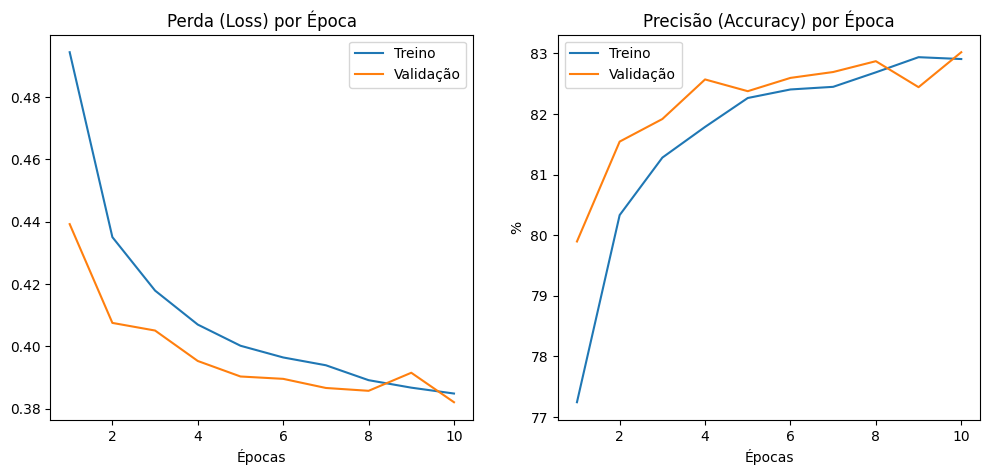

In [8]:
#  GRÁFICOS DE COMPARAÇÃO DE LOSS E ACCURACY PARA TESTE E VALIDAÇÃO 
def plot_results(train_losses, val_losses, train_accs, val_accs):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Gráfico de Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Treino')
    plt.plot(epochs_range, val_losses, label='Validação')
    plt.title('Perda (Loss) por Época')
    plt.xlabel('Épocas')
    plt.legend()

    # Gráfico de Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Treino')
    plt.plot(epochs_range, val_accs, label='Validação')
    plt.title('Precisão (Accuracy) por Época')
    plt.xlabel('Épocas')
    plt.ylabel("%")
    plt.legend()

    plt.show()

plot_results(train_losses, val_losses, train_accs, val_accs)

A extrair e achatar imagens para o Random Forest...


Convertendo dados: 100%|███████████████████████████████████████████████████████████| 4899/4899 [06:41<00:00, 12.20it/s]


A extrair e achatar imagens para o Random Forest...


Convertendo dados: 100%|█████████████████████████████████████████████████████████████| 613/613 [00:51<00:00, 11.79it/s]



A treinar Random Forest com 156748 imagens...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.2s


building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100building tree 67 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


 ACCURACY RANDOM FOREST: 77.20%


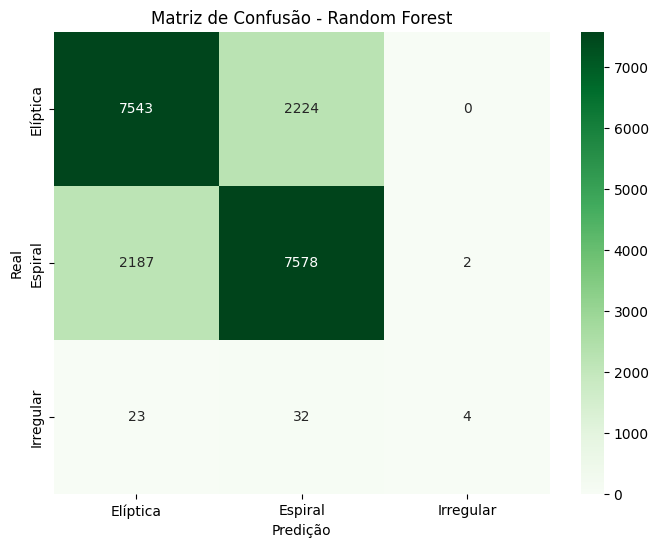

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Elíptica       0.77      0.77      0.77      9767
     Espiral       0.77      0.78      0.77      9767
   Irregular       0.67      0.07      0.12        59

    accuracy                           0.77     19593
   macro avg       0.74      0.54      0.56     19593
weighted avg       0.77      0.77      0.77     19593



In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score


# aplicar random forest nos dados de validação (val) para comparar qual melhor método

# FUNÇÃO PARA CONVERTER IMAGENS EM VETORES, PROCESSO DE FLATTEN
def prepare_data_for_rf(loader):
    # Converte o dataloader de Tensores para matrizes numpy.
    # Transforma a imagem 64x64x3 num vetor único de 12.288 números.
    all_features = []
    all_labels = []
    
    print("A extrair e achatar imagens para o Random Forest...")
    for images, labels in tqdm(loader, desc="Convertendo dados"):
        # passar imagens [batch, 3, 64, 64] para matriz [batch, 12288]
        flattened = images.view(images.size(0), -1).numpy()
        all_features.append(flattened)
        all_labels.append(labels.numpy())

    # juntar os batches 
    return np.vstack(all_features), np.concatenate(all_labels)

# Preparar os dados para usar rf
X_train_rf, y_train_rf = prepare_data_for_rf(train_loader)
X_val_rf, y_val_rf = prepare_data_for_rf(val_loader)

# TREINO
print(f"\nA treinar Random Forest com {len(X_train_rf)} imagens...")

# n_estimators - número de árvores
# n_jobs=-1 - usa todos os núcleos do CPU para ser mais rápido
rf_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbose=2)

# análise das árvores.
rf_classifier.fit(X_train_rf, y_train_rf)

# AVALIAÇÃO
y_pred_rf = rf_classifier.predict(X_val_rf)

acc_rf = accuracy_score(y_val_rf, y_pred_rf)

print('=' * 40)
print(f" ACCURACY RANDOM FOREST: {acc_rf*100:.2f}%")
print('=' * 40)

# --- CRIAÇÃO DA MATRIZ DE CONFUSÃO ---

# Definir os nomes das classes na ordem correta (0(eliptica), 1(espiral), 2(irregular) )
class_names = ['Elíptica', 'Espiral', 'Irregular']
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_val_rf, y_pred_rf)

# --- VISUALIZAÇÃO COM SEABORN ---
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

print("CLASSIFICATION REPORT")
print(classification_report(y_val_rf, y_pred_rf, target_names=['Elíptica', 'Espiral', 'Irregular']))

A gerar Matriz de Confusão: 100%|█████████████████████████████████████████████████| 613/613 [01:51<00:00,  5.48batch/s]


 ACCURACY GERAL DO MODELO: 82.94%


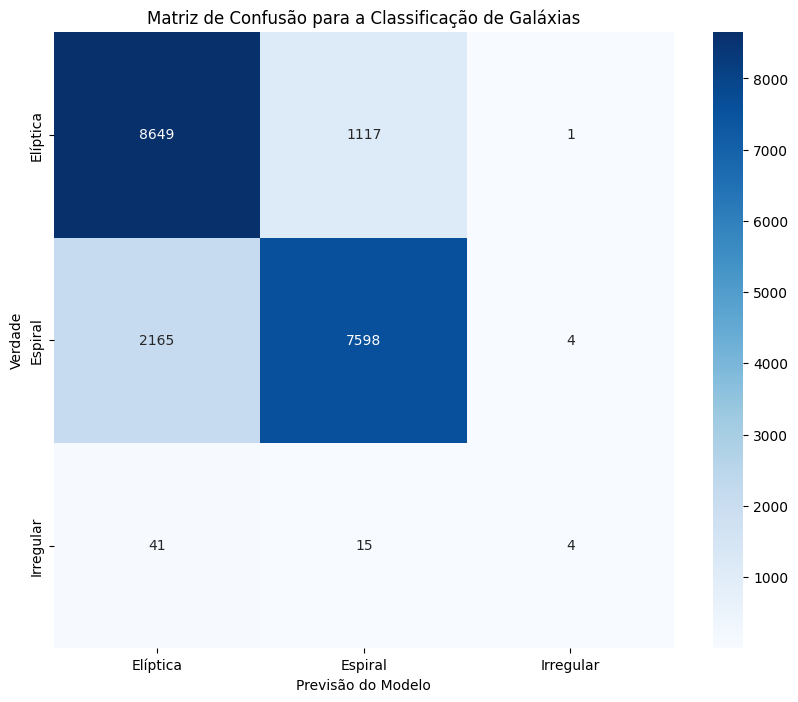


Classification Report:
              precision    recall  f1-score   support

    Elíptica       0.80      0.89      0.84      9767
     Espiral       0.87      0.78      0.82      9767
   Irregular       0.44      0.07      0.12        60

    accuracy                           0.83     19594
   macro avg       0.70      0.58      0.59     19594
weighted avg       0.83      0.83      0.83     19594



In [7]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns

# TESTE FINAL COM DADOS DE TESTE 

# Carregar os pesos e bias do melhor modelo encontrado durante o treino
model.load_state_dict(torch.load('melhor_modelo_galaxia.pth'))
model.to(device)
model.eval()

# acumular os resultados de todos os batches do teste
all_preds = []
all_labels = []

pbar_test = tqdm(test_loader, desc='A gerar Matriz de Confusão', unit='batch')

with torch.no_grad():
    for images, labels in pbar_test:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Guardar as previsões e as labels reais
        # .cpu necessários pois os resultados calculados do PyTorch pela GPU precisam de ser para a CPU para comunicarem com numpy, etc.
        # .numpy() converte de tensor PyTorch para uma lista comum de numpy
        # .extend adiciona esses novos resultados às nossas listas acumuladoras
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# accuracy total (F1-score é uma métrica melhor para analisar se o resultado é bom, pois representa os resultados de cada classe)
acc = accuracy_score(all_labels, all_preds)
print('=' * 40)
print(f' ACCURACY GERAL DO MODELO: {acc*100:.2f}%')
print('=' * 40)



# --- CRIAÇÃO DA MATRIZ DE CONFUSÃO ---
class_names = ['Elíptica', 'Espiral', 'Irregular']

cm = confusion_matrix(all_labels, all_preds)

# --- VISUALIZAÇÃO COM SEABORN ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Previsão do Modelo')
plt.ylabel('Verdade')
plt.title('Matriz de Confusão para a Classificação de Galáxias')
plt.show()

# Informações estatísticas adicionais para avaliar modelo e resultados (Precision, Recall, F1-Score)

# Precision - percentagem de vezes que acertou classe (evitar falsos positivos)
# Recall - De todas as galáxias que pertenciam a uma classe, quantas o modelo acertou (evitar falsos negativos)
# F1-Score - Média dos 2 anteriores
# support - quantidade de imagens em cada classe
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))